# Predict target features (brown dwarf parameters) using trained CNN model

In [1]:
import sys  
sys.path.insert(0, '../telescopeML/')

from ObservPredictor import *
from DeepRegBuilder import *
from StatVisAnalyzer import regression_report, chi_square_test, plot_chi_square_p_value

Loading BokehJS ...

Loading BokehJS ...

# Step 1: Load the training dataset (syntheric spectra)

In [2]:
# original trainign dataset astronomers use to predict the parameters of the telescope brown dwarf spectra

train_BD = pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
train_BD.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


### Check the columns
note: one of the columns, *is_augmented*, is indicating wheter this is a native dataset or an augmented one. For now, we don't need it so drop it, but all modules will take this into account! 

In [3]:
target_features = ['gravity', 'temperature', 'c_o_ratio', 'metallicity']
train_BD[target_features].head()

,gravity,temperature,c_o_ratio,metallicity
0,5.0,1100,0.25,-1.0
1,5.0,1100,0.25,-0.7
2,5.0,1100,0.25,-0.5
3,5.0,1100,0.25,-0.3
4,5.0,1100,0.25,0.0


In [4]:
training_features_labels = [item for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_labels[:5]

['2.512', '2.487', '2.462', '2.438', '2.413']

In [5]:
training_features_wl = [float(item) for item in train_BD.columns.to_list() if item not in target_features+['is_augmented']]
training_features_wl[:5]

[2.512, 2.487, 2.462, 2.438, 2.413]

In [6]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


## Prepare feature variables (X) and targets (y)

In [7]:
# to assure we are only training the module with the native non-augmented BD training dataset
train_BD = train_BD[train_BD['is_augmented'].isin(['no'])] 


# Training feature variables
X = train_BD.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)


# Target feature variables
y = train_BD[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [8]:
y.loc[:, 'temperature'] = np.log10(y['temperature'])

/var/folders/30/n2yd25m90v1bywy0rcgx4fqc0000gq/T/ipykernel_60014/1983952283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, 'temperature'] = np.log10(y['temperature'])


In [9]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Build the CNN model / Data processing

In [10]:
# Instintiate TrainCNNRegression class
train_cnn_regression = TrainRegression(feature_values=X.to_numpy(),
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

#### Split the dataset into train, validate and test sets

In [11]:
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [12]:
# Scale the X features using MinMax Scaler
train_cnn_regression.standardize_X_row_wise()

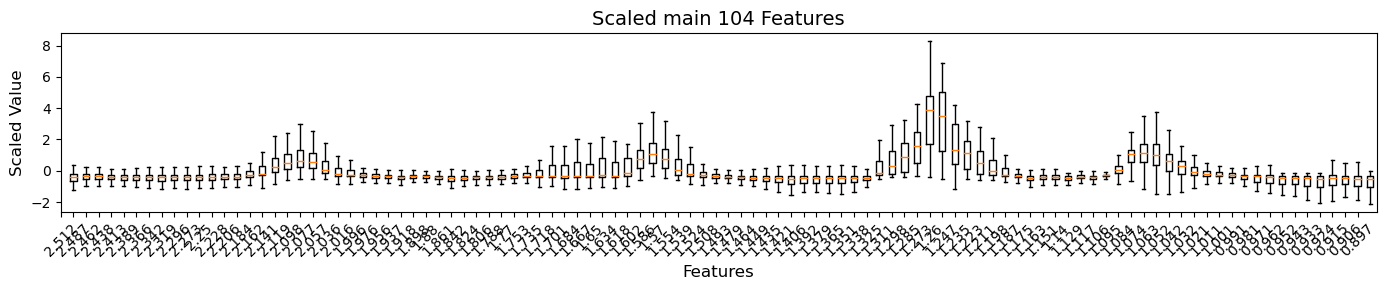

In [13]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.X_train_standardized_rowwise, 
                                                  xticks_list = training_features_labels,
                                                  title = 'Scaled main 104 Features',
                                                  fig_size=(14, 3),
                                                    )

### Scale y features - ColumnWise

In [14]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

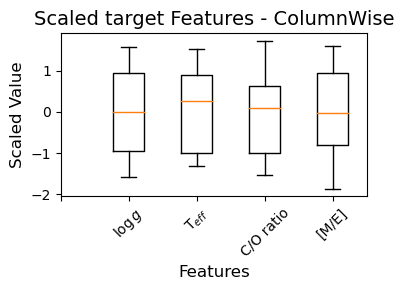

In [15]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.y_train_standardized_columnwise, 
                                                  xticks_list = ['','$\log g$', 'T$_{eff}$', 'C/O ratio', '[M/E]'],
                                                  title = 'Scaled target Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

In [16]:
# train_cnn_regression.y_train_standardized_columnwise

### Feature engeenering: Take Min and Max of each row (BD spectra) 

In [17]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [18]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [19]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [20]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [21]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [22]:
df_MinMax_train.head()

,min,max
0,8.265340e-12,3.445259e-08
1,8.080712e-22,8.397132e-14
2,2.734403e-07,8.632182e-06
3,4.414951e-16,3.373262e-10
4,3.722576e-07,6.859888e-06


### Scale Min Max features - ColumnWise

In [23]:
train_cnn_regression.standardize_X_column_wise(
                                                X_train = df_MinMax_train.values,
                                                X_val   = df_MinMax_val.values,
                                                X_test  = df_MinMax_test.values,
                                                )

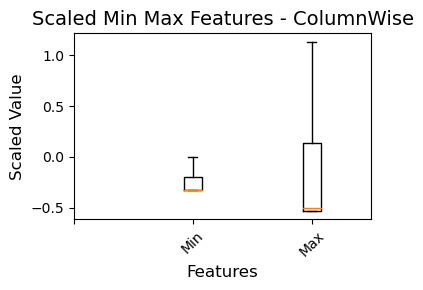

In [24]:
train_cnn_regression.plot_boxplot_scaled_features(scaled_feature= train_cnn_regression.X_test_standardized_columnwise, 
                                                  xticks_list = ['','Min','Max'],
                                                  title = 'Scaled Min Max Features - ColumnWise',
                                                  fig_size=(4, 3),
                                                    )

# Step 3: Load the Trained CNN model

In [25]:
# model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters_v1.h5')
# model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters_v1.h5')

# # Loading the saved history object
# with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters_v1.pkl', 'rb') as file:
#     history = pk.load(file)    

In [26]:
from tensorflow.keras.models import load_model
model = load_model('../../outputs/trained_models/trained_CNN_architecture_Toy_parameters_v4_1000epoch_v2.h5')
model.load_weights('../../outputs/trained_models/trained_CNN_weights_Toy_parameters_v4_1000epoch_v2.h5')

# Loading the saved history object
with open('../../outputs/trained_models/trained_CNN_history_Toy_parameters_v4_1000epoch_v2.pkl', 'rb') as file:
    history = pk.load(file)    

2023-07-28 15:23:00.870663: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

### Check the CNN archeticture

In [28]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                # to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
#                 show_layer_activations=False,
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [29]:
train_cnn_regression.trained_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 104, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 102, 32)      128         input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 100, 64)      6208        conv1d_20[0][0]                  
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 98, 128)      24704       conv1d_21[0][0]                  
____________________________________________________________________________________________

### Check the performance of the trained models

In [30]:
train_cnn_regression.plot_model_loss(history=history, title = 'X:StandRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Plot predicted Vs. Actual outcomes: Histogram & Scatter plot

2023-07-28 15:23:01.363979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


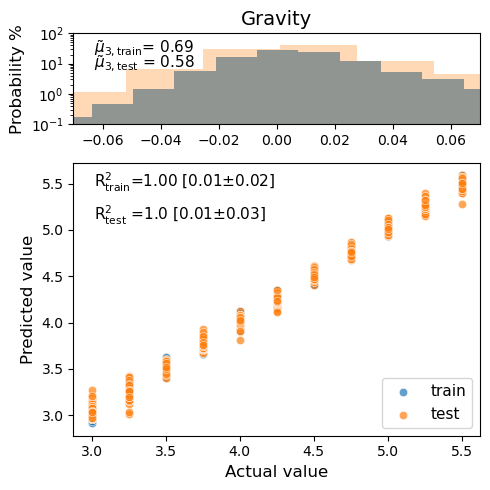

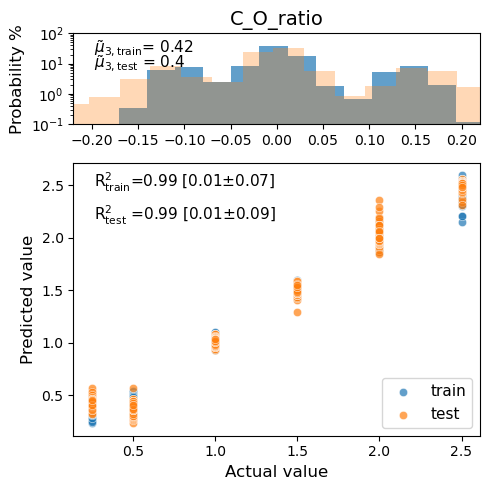

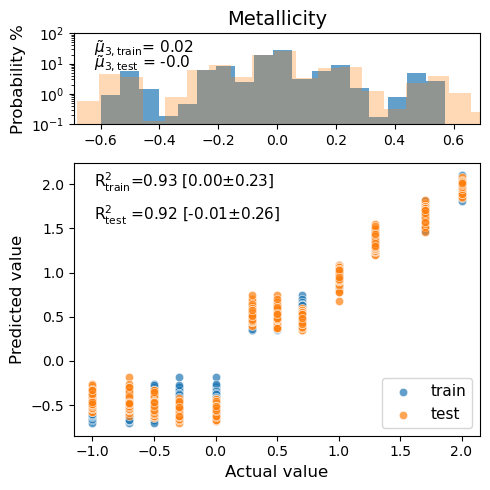

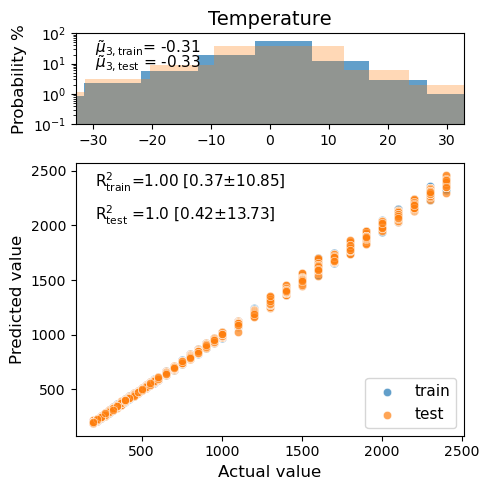

In [31]:
i = 1
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_standardized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_standardized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

# Step 4: Predict Observational data using the trained CNN model

Steps: 
- Define the literature reported data for the object
- Instintiate ObsParameterPredictor class
- load_observational_spectra
    - replace negative Flam with zero
    - take the average of neibougrs for Flam_error <= 0
    - plot_observational_spectra_errorbar_
- Process_Observational_Dataset
    - Instintiate ProcessObservationalDataset class
    - define feature_names_synthetic and feature_names_obs
    - flux_interpolated
    - 

In [32]:
# define the brown dwarf literature data for Teff, logg, [M/H], and C/O
# ... and also the distance to the object [in pc] and its radius in Rjup



---

## HD 3651B

In [61]:
HD3651B_BD_literature_info = {'bd_name':'HD3651B',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 11.134, 
          'bd_radius_Rjup' : 0.81,
          'bd_radius_Rjup_tuned': None} #0.81


In [62]:
brown_dwarf_literature_info = HD3651B_BD_literature_info
predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = train_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [63]:
predict.load_observational_spectra()

In [64]:
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.3521357774734497,
    'gravity': 5.0839948654174805,
    'metallicity': -0.331138551235199,
    'temperature': 821.6129150390625}
******************************

            logg        c_o        met           T
count  10.000000  10.000000  10.000000   10.000000
mean    5.083995   1.352136  -0.331139  821.612915
std     0.147513   0.197319   0.169035   32.871750
min     4.825476   1.111413  -0.435426  756.062866
25%     4.969253   1.241237  -0.418241  810.563446
50%     5.094169   1.272053  -0.400207  820.154205
75%     5.192264   1.445061  -0.322697  838.201721
max     5.305728   1.686286   0.125585  870.604675


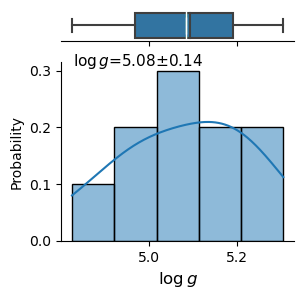

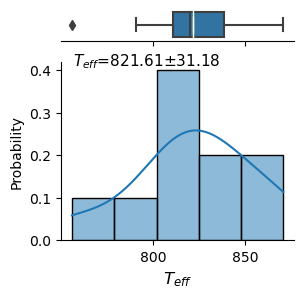

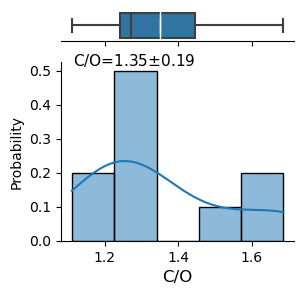

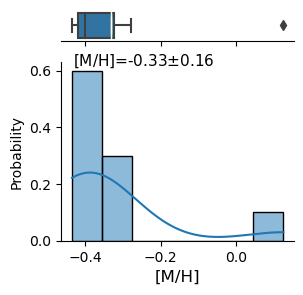

In [65]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [66]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.81 R_Jup:  𝛘2 = 129.89, p-value = 3.78e-02


(129.89, '3.78e-02')

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [39]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = train_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [40]:
brown_dwarf_literature_info

{'bd_name': 'HD3651B',
 'bd_Teff': 818,
 'bd_logg': 3.94,
 'bd_met': -0.22,
 'bd_distance_pc': 11.134,
 'bd_radius_Rjup': 0.81,
 'bd_radius_Rjup_tuned': None}

In [41]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.1, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.1, 
                                                    dR = 0.02,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

Radius = 0.71 R_Jup:  𝛘2 = 117.66, p-value = 1.53e-01
Radius = 0.74 R_Jup:  𝛘2 = 123.44, p-value = 8.30e-02
Radius = 0.76 R_Jup:  𝛘2 = 100.45, p-value = 5.53e-01
Radius = 0.79 R_Jup:  𝛘2 = 48.33, p-value = 1.00e+00
Radius = 0.81 R_Jup:  𝛘2 = 68.17, p-value = 9.97e-01
Radius = 0.84 R_Jup:  𝛘2 = 116.26, p-value = 1.75e-01
Radius = 0.86 R_Jup:  𝛘2 = 66.62, p-value = 9.98e-01
Radius = 0.89 R_Jup:  𝛘2 = 148.13, p-value = 2.40e-03
Radius = 0.91 R_Jup:  𝛘2 = 250.63, p-value = 2.58e-14


In [42]:
# closest_chi_square, closest_p_value = find_closest_chi_square(df_value, chi_square_list)

# print("Closest Chi-Square Statistic:", closest_chi_square)
# print("P-value:", closest_p_value)

---

## Ross 458C

In [43]:
Ross458C_BD_literature_info = {'bd_name':'Ross458C',
          'bd_Teff':804,
          'bd_logg':4.09,
          'bd_met': 0.23, 
          'bd_distance_pc' : 11.509, 
          'bd_radius_Rjup' :  0.68,
          'bd_radius_Rjup_tuned': None } #1.0 * 0.68 


In [44]:
brown_dwarf_literature_info = Ross458C_BD_literature_info
predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = train_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [45]:
predict.load_observational_spectra()

In [46]:
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

******************************

Predicted Targets from Randomly Generated Spectra:
{   'c_o_ratio': 1.178712248802185,
    'gravity': 4.823060035705566,
    'metallicity': 0.8635591268539429,
    'temperature': 973.6976318359375}
******************************

            logg        c_o        met            T
count  10.000000  10.000000  10.000000    10.000000
mean    4.823060   1.178712   0.863559   973.697632
std     0.152682   0.119372   0.112604    34.467087
min     4.639269   1.008397   0.701020   929.804504
25%     4.702542   1.116052   0.768054   949.300995
50%     4.820454   1.160467   0.902019   973.839874
75%     4.899916   1.206504   0.932449   982.740356
max     5.134195   1.443475   1.033265  1052.518921


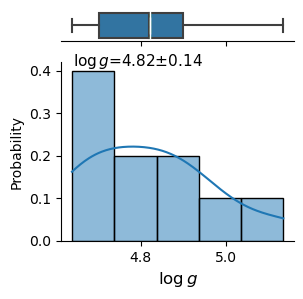

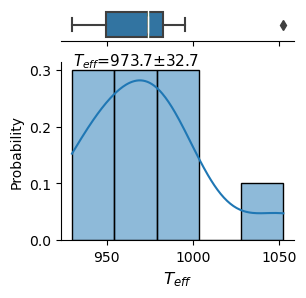

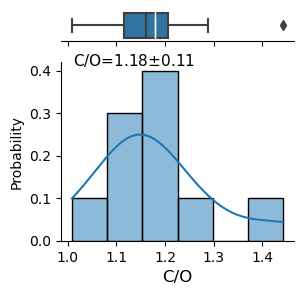

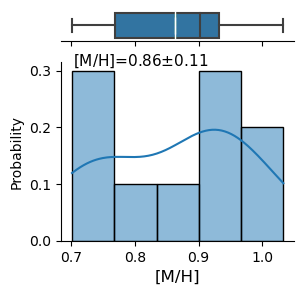

In [47]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [48]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

Radius = 0.68 R_Jup:  𝛘2 = 506.93, p-value = 0.00e+00


(506.93, '0.00e+00')

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [49]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = train_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [50]:
brown_dwarf_literature_info

{'bd_name': 'Ross458C',
 'bd_Teff': 804,
 'bd_logg': 4.09,
 'bd_met': 0.23,
 'bd_distance_pc': 11.509,
 'bd_radius_Rjup': 0.68,
 'bd_radius_Rjup_tuned': None}

In [51]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.3, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.3, 
                                                    dR = 0.01,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

Radius = 0.38 R_Jup:  𝛘2 = 696.18, p-value = 0.00e+00
Radius = 0.39 R_Jup:  𝛘2 = 230.42, p-value = 9.55e-12
Radius = 0.40 R_Jup:  𝛘2 = 887.64, p-value = 0.00e+00
Radius = 0.41 R_Jup:  𝛘2 = 556.15, p-value = 0.00e+00
Radius = 0.42 R_Jup:  𝛘2 = 599.1, p-value = 0.00e+00
Radius = 0.43 R_Jup:  𝛘2 = 279.72, p-value = 0.00e+00
Radius = 0.44 R_Jup:  𝛘2 = 394.6, p-value = 0.00e+00
Radius = 0.45 R_Jup:  𝛘2 = 264.53, p-value = 3.33e-16
Radius = 0.46 R_Jup:  𝛘2 = 601.11, p-value = 0.00e+00
Radius = 0.47 R_Jup:  𝛘2 = 623.87, p-value = 0.00e+00
Radius = 0.48 R_Jup:  𝛘2 = 850.59, p-value = 0.00e+00
Radius = 0.49 R_Jup:  𝛘2 = 642.28, p-value = 0.00e+00
Radius = 0.50 R_Jup:  𝛘2 = 875.42, p-value = 0.00e+00
Radius = 0.51 R_Jup:  𝛘2 = 401.88, p-value = 0.00e+00
Radius = 0.52 R_Jup:  𝛘2 = 1205.74, p-value = 0.00e+00
Radius = 0.54 R_Jup:  𝛘2 = 361.36, p-value = 0.00e+00
Radius = 0.55 R_Jup:  𝛘2 = 608.21, p-value = 0.00e+00
Radius = 0.56 R_Jup:  𝛘2 = 471.39, p-value = 0.00e+00
Radius = 0.57 R_Jup:  𝛘2 = 43

In [52]:
# closest_chi_square, closest_p_value = find_closest_chi_square(df_value, chi_square_list)

# print("Closest Chi-Square Statistic:", closest_chi_square)
# print("P-value:", closest_p_value)

---

## GJ 570D

In [53]:
GJ570D_BD_literature_info = {'bd_name':'GJ570D',
          'bd_Teff':818,
          'bd_logg':3.94,
          'bd_met': -0.22, 
          'bd_distance_pc' : 5.884, 
          'bd_radius_Rjup' : 0.79,
          'bd_radius_Rjup_tuned': None } # 0.79

In [54]:
brown_dwarf_literature_info = GJ570D_BD_literature_info

predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                training_dataset_df = train_BD,
                                wl = wl, 
                                train_cnn_regression_class = train_cnn_regression,
                                bd_literature_dic = brown_dwarf_literature_info
                                )

In [55]:
predict.load_observational_spectra()

In [56]:
predict.Process_Observational_Dataset(
    __print_results__=False,
    __plot_predicted_vs_observed__=False,
    )

In [57]:
predict.predict_from_random_spectra(random_spectra_num= 10,
                                     __print_results__= True,
                                     __plot_randomly_generated_spectra__= False,
                                     __plot_histogram__= False,
                                     __plot_boxplot_hist__= True,
                                     __plot_predicted_vs_observed__= False,
                                     __plot_predicted_vs_spectra_errorbar__= False,
                                     __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = True,
                                     __calculate_confidence_intervals_std_df__ = True,
                                    )

KeyError: 'gravity'

### Tune the brown dwarf Radius

#### What is the 𝛘2 value for the predicted ML vs. the observational spectra?

In [ ]:
chi_square_test(x_obs = predict.obs_data_df['wl'][2:], 
                y_obs = predict.Fnu_obs_absolute[2:], 
                yerr_obs = predict.Fnu_obs_absolute_err[2:],
                
                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                y_pre = predict.confidence_intervals_std_df['mean'], 
                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                radius = brown_dwarf_literature_info['bd_radius_Rjup'],
                __plot_results__ = False,
                __print_results__ = True)

#### What is the 𝛘2 value (and p-value) for a range of $R_{Jup}$ radius?

In [ ]:
def tune_radius(Rmin=0.7, Rmax=1.2, dR=0.1,
                brown_dwarf_literature_info = None,
                __plot_results__ = False,
               __print_results__ = True,
               __plot_stat_results__ = True):
    R_list = []
    chi_square_list = []
    p_value_list = []

    for radius in list( np.linspace(Rmin, Rmax, num=int((Rmax-Rmin)/dR) )):
        
        brown_dwarf_literature_info['bd_radius_Rjup_tuned'] = radius
        
        predict = ObsParameterPredictor(object_name = brown_dwarf_literature_info['bd_name'], #Ross458C, HD3651B, GJ570D
                                        training_dataset_df = train_BD,
                                        wl = wl, 
                                        train_cnn_regression_class = train_cnn_regression,
                                        bd_literature_dic = brown_dwarf_literature_info
                                        )
        predict.load_observational_spectra()

        predict.Process_Observational_Dataset(
        __print_results__=False,
        __plot_predicted_vs_observed__=False,
        )

        predict.predict_from_random_spectra(random_spectra_num= 5,
                                             __print_results__= False,
                                             __plot_randomly_generated_spectra__= False,
                                             __plot_histogram__= False,
                                             __plot_boxplot_hist__= False,
                                             __plot_predicted_vs_observed__= False,
                                             __plot_predicted_vs_spectra_errorbar__= False,
                                             __plot_predictedRandomSpectra_vs_ObservedSpectra_errorbar__ = False,
                                             __calculate_confidence_intervals_std_df__ = True,
                                            )

        data1 = predict.Fnu_obs_absolute
        error1 = predict.Fnu_obs_absolute_err
        x1 = predict.obs_data_df['wl']

        data2 = predict.confidence_intervals_std_df['mean']
        error2 = predict.confidence_intervals_std_df['std_values']
        x2 = predict.confidence_intervals_std_df['wl'].values[::-1]

        # plot_with_errorbars(x1, data1, error1, x2, data2, error2, title="Data with Error Bars")

        chi_square, p_value = chi_square_test(x_obs = predict.obs_data_df['wl'], 
                                y_obs = predict.Fnu_obs_absolute, 
                                yerr_obs = predict.Fnu_obs_absolute_err,

                                x_pre = predict.confidence_intervals_std_df['wl'].values[::-1], 
                                y_pre = predict.confidence_intervals_std_df['mean'], 
                                yerr_pre = predict.confidence_intervals_std_df['std_values'],
                                radius = radius,
                                __plot_results__ = False,
                                __print_results__ = False)
        
        if chi_square >= 0.:
            R_list.append(radius)
            chi_square_list.append(chi_square)
            p_value_list.append(np.float128(p_value))
        else:
            pass

        if __print_results__:
            print( f"Radius = {'{:.2f}'.format(radius)} R_Jup:  𝛘2 = {chi_square}, p-value = {p_value}")
            
    if __plot_stat_results__:
        plot_chi_square_p_value(R_list, chi_square_list, p_value_list)
    
    return R_list, chi_square_list, p_value_list

In [ ]:
brown_dwarf_literature_info

In [ ]:
R_list, chi_square_list, p_value_list = tune_radius(Rmin = brown_dwarf_literature_info['bd_radius_Rjup']- 0.1, 
                                                    Rmax = brown_dwarf_literature_info['bd_radius_Rjup']+ 0.1, 
                                                    dR = 0.01,
                                                    brown_dwarf_literature_info = brown_dwarf_literature_info,
                                                    __plot_results__=False,
                                                    __print_results__=True,
                                                    __plot_stat_results__=True,)

In [ ]:
# closest_chi_square, closest_p_value = find_closest_chi_square(df_value, chi_square_list)

# print("Closest Chi-Square Statistic:", closest_chi_square)
# print("P-value:", closest_p_value)

---

# END ------